<div style="border-radius: 15px; border: 2px solid #6A1B9A; padding: 20px; background: linear-gradient(135deg, #9C27B0, #4CAF50); text-align: center; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <h1 style="color: #ffffff; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); font-weight: bold; margin-bottom: 10px; font-size: 36px; font-family: 'Roboto', sans-serif;">
        🧠 Random Forests: Decoding Personality Traits 🌿
    </h1>
</div>

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">

In this notebook, we build a classification model to distinguish **Introverts** from **Extroverts** based on behavioral features. We'll walk through the full ML workflow:

- Data preprocessing and feature engineering
- Cross-validation with Random Forest
- Evaluation using accuracy, confusion matrix, calibration curves
- Generating predictions for submission
- Visualizing feature importances

> Note: An auxiliary dataset (`personality_datasert.csv`) is used to enrich the training and test sets.


Skipping Optuna. Using Best Trial Parameters...

Cross-validation training...

--- Fold 1 ---
Fold 1 Accuracy: 0.9706

--- Fold 2 ---
Fold 2 Accuracy: 0.9679

--- Fold 3 ---
Fold 3 Accuracy: 0.9660

--- Fold 4 ---
Fold 4 Accuracy: 0.9706

--- Fold 5 ---
Fold 5 Accuracy: 0.9714

Mean Cross-Validation Accuracy: 0.9693

Classification Report:
               precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.95      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



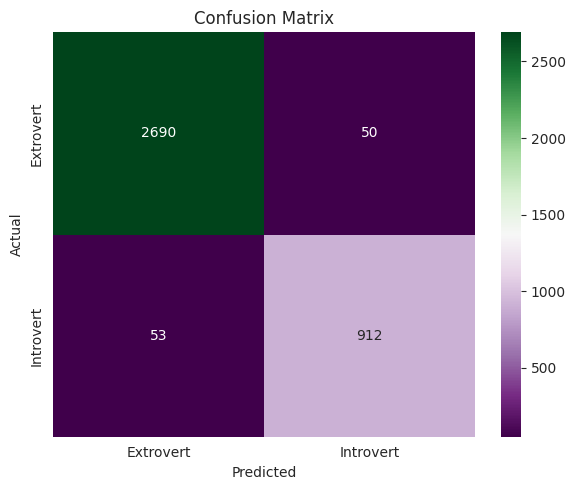

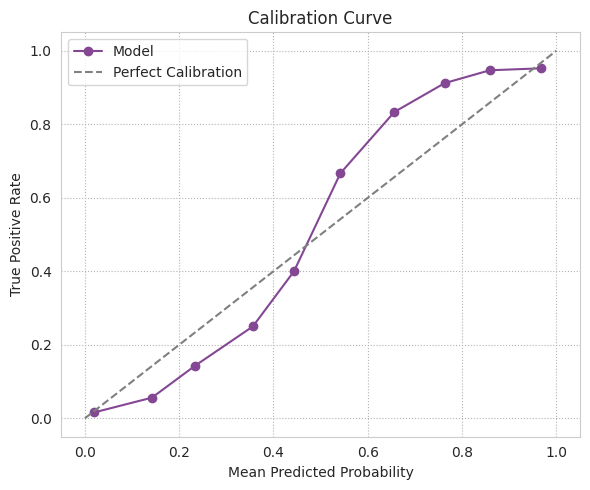

Accuracy 95% Confidence Interval: [0.6011, 0.6292]

Plotting feature importances...


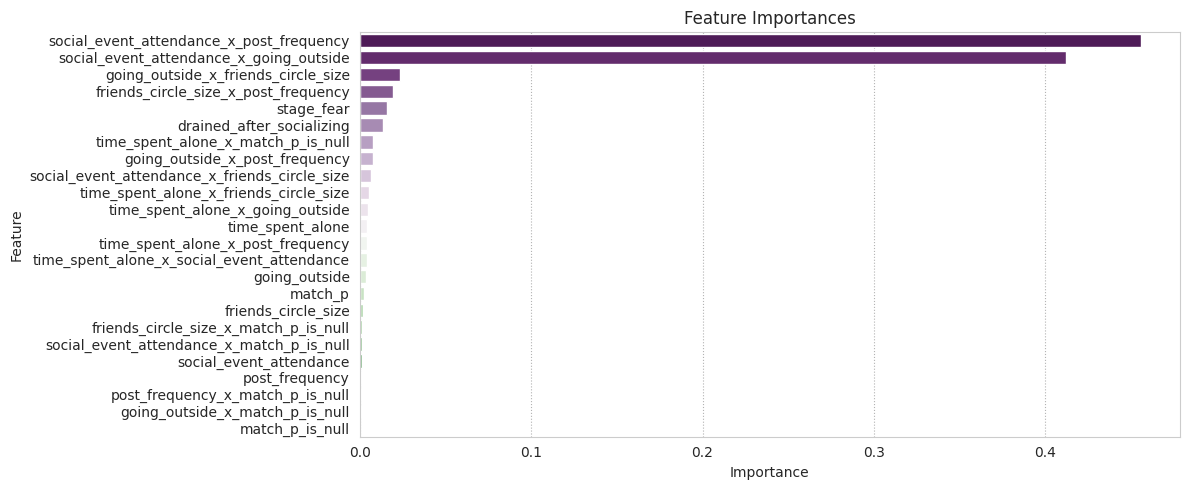


Generating final submission...

Generating submission file...
Submission file saved!

Prediction Counts:
Personality
Extrovert    4623
Introvert    1552
Name: count, dtype: int64


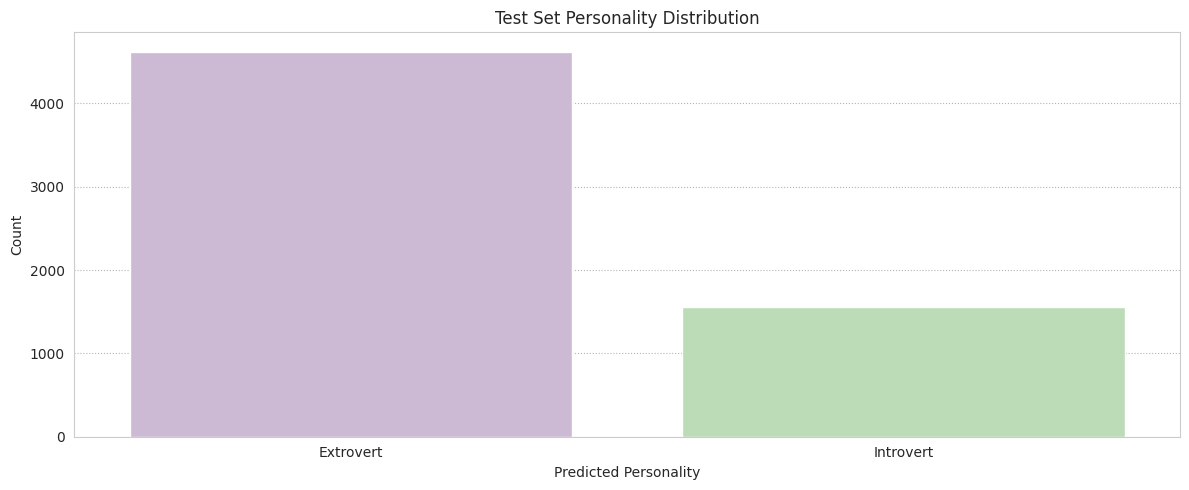

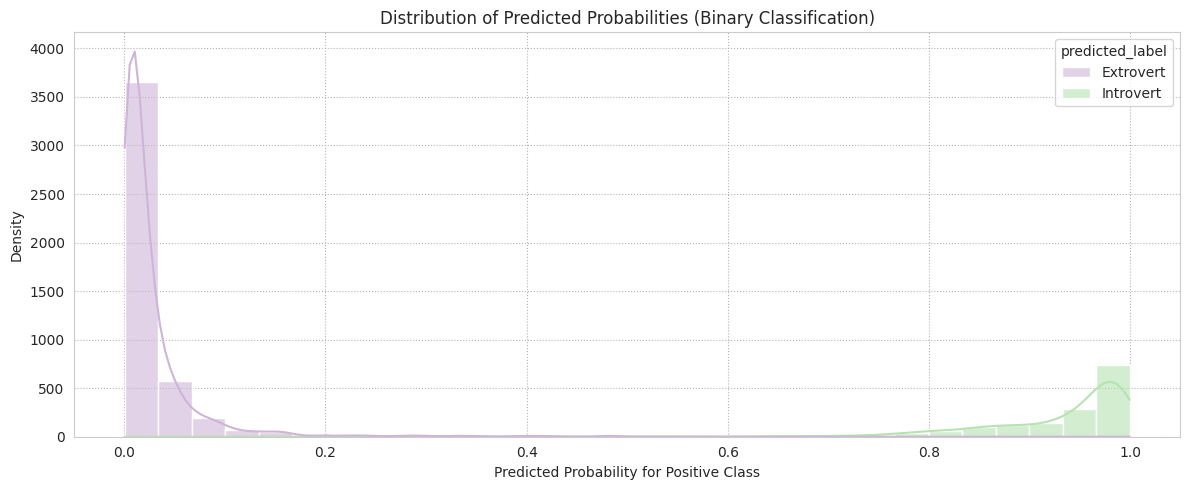

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert


In [1]:
# ================================
#            IMPORTS
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings("ignore")

# ================================
#         VISUAL SETTINGS
# ================================
sns.set_palette("PRGn")
sns.set_style("whitegrid", {
    'grid.color': '.7',
    'grid.linestyle': ':',
    'grid.linewidth': 0.7
})

# ================================
#         PREPROCESSING
# ================================
def preprocess_data(original, train, test):
    # Match records from the original dataset
    original = original.rename(columns={'Personality': 'match_p'})
    original = original.drop_duplicates(subset=original.drop(columns='match_p').columns.tolist())
    
    train = train.merge(original, how='left')
    test = test.merge(original, how='left')

    # Separate features and target
    X = train.drop(columns=['Personality'])
    y = train['Personality']

     # Encode the target variable
    label_encoder = LabelEncoder()
    y_encoded = pd.Series(label_encoder.fit_transform(y))

    return X, test, y_encoded, label_encoder

# ================================
#      FEATURE ENGINEERING
# ================================
def feature_engineering(X_train, X_val):
    X_train = X_train.copy()
    X_val = X_val.copy()

    for df in [X_train, X_val]:
        df.columns = df.columns.str.lower().str.replace(' ', '_')
        df.drop(columns=[col for col in ['id'] if col in df.columns], inplace=True)
        df['stage_fear'] = df['stage_fear'].fillna('unknown')
        df['drained_after_socializing'] = df['drained_after_socializing'].fillna('unknown')
        df['match_p_is_null'] = df['match_p'].isna().astype(int)
        df['match_p'] = df['match_p'].fillna('unknown')

        for col in df.select_dtypes(include='number').columns:
            df[col] = df[col].fillna(df[col].mean())

    # Create cross-term features (pairwise products of numerical variables)
    num_cols = X_train.select_dtypes(include='number').columns.tolist()
    for i in range(len(num_cols)):
        for j in range(i + 1, len(num_cols)):
            feat_name = f"{num_cols[i]}_x_{num_cols[j]}"
            X_train[feat_name] = X_train[num_cols[i]] * X_train[num_cols[j]]
            X_val[feat_name] = X_val[num_cols[i]] * X_val[num_cols[j]]

    cat_cols = X_train.select_dtypes(include='object').columns.tolist()
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
    X_val[cat_cols] = encoder.transform(X_val[cat_cols])

    return X_train, X_val

# ================================
#        MODEL TRAINING
# ================================
def fit_cross_val_model(X, y, model, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    models, scores = [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n--- Fold {fold} ---")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train_prep, X_val_prep = feature_engineering(X_train, X_val)

        model.fit(X_train_prep, y_train)
        preds = model.predict(X_val_prep)
        acc = accuracy_score(y_val, preds)

        print(f"Fold {fold} Accuracy: {acc:.4f}")
        scores.append(acc)
        models.append(model)

    print(f"\nMean Cross-Validation Accuracy: {np.mean(scores):.4f}")
    return models, np.mean(scores)

# ================================
#           EVALUATION
# ================================
def evaluate_model(model, X_val, y_val, label_encoder):
    preds = model.predict(X_val)
    report = classification_report(y_val, preds, target_names=label_encoder.classes_)
    cm = confusion_matrix(y_val, preds)

    print("\nClassification Report:\n", report)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="PRGn", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Calibration Curve
    if len(np.unique(y_val)) == 2:
        prob_pos = model.predict_proba(X_val)[:, 1]
        prob_true, prob_pred = calibration_curve(y_val, prob_pos, n_bins=10)

        plt.figure(figsize=(6, 5))
        plt.plot(prob_pred, prob_true, marker='o', label='Model')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("True Positive Rate")
        plt.title("Calibration Curve")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Confidence Interval via Bootstrap
        bootstrap_acc = [
            accuracy_score(y_val.iloc[np.random.choice(len(y_val), len(y_val), replace=True)], preds)
            for _ in range(1000)
        ]
        ci_lower, ci_upper = np.percentile(bootstrap_acc, [2.5, 97.5])
        print(f"Accuracy 95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ================================
#         SUBMISSION
# ================================
def generate_submission(models, X_test, label_encoder, test_df, output_file='submission.csv'):
    print("\nGenerating submission file...")

    # Average predicted probabilities from all models
    probs = np.mean([model.predict_proba(X_test) for model in models], axis=0)
    preds = np.argmax(probs, axis=1)
    predicted_labels = label_encoder.inverse_transform(preds)

    # Create submission DataFrame
    submission = pd.DataFrame({
        'id': test_df['id'],
        'Personality': predicted_labels
    })
    submission.to_csv(output_file, index=False)
    print(f"Submission file saved!")

    print("\nPrediction Counts:")
    print(submission['Personality'].value_counts())

    # Distribution of predicted classes
    plt.figure(figsize=(12, 5))
    sns.countplot(data=submission, x='Personality', palette='PRGn')
    plt.title("Test Set Personality Distribution")
    plt.xlabel("Predicted Personality")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Plot predicted probability distribution
    if probs.shape[1] == 2:
        proba_df = pd.DataFrame({
            'prob_class_1': probs[:, 1],
            'predicted_label': predicted_labels
        })

        plt.figure(figsize=(12, 5))
        sns.histplot(
            data=proba_df,
            x='prob_class_1',
            hue='predicted_label',
            bins=30,
            kde=True,
            palette='PRGn',
            alpha=0.6
        )
        plt.title("Distribution of Predicted Probabilities (Binary Classification)")
        plt.xlabel("Predicted Probability for Positive Class")
        plt.ylabel("Density")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    display(submission.head())
    
# ================================
#     FEATURE IMPORTANCE
# ================================
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 5))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette='PRGn')
    plt.title("Feature Importances")
    plt.tight_layout()
    plt.show()

# ================================
#        MAIN PIPELINE
# ================================
def run_pipeline():
    # Load data
    train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
    test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
    original = pd.read_csv('/kaggle/input/extrovert-vs-introvert-behavior-data-backup/personality_datasert.csv')

    # Preprocess and encode
    X, test_processed, y, label_encoder = preprocess_data(original, train, test)
    _, X_test = feature_engineering(X, test_processed)

    print("Skipping Optuna. Using Best Trial Parameters...")
    # Use optimized parameters
    best_params = {
        'n_estimators': 335,
        'max_depth': 17,
        'min_samples_split': 10,
        'min_samples_leaf': 3,
        'max_features': None,
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**best_params)

    # Cross-validation
    print("\nCross-validation training...")
    models, _ = fit_cross_val_model(X, y, model)

    # Hold-out evaluation
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)
    X_train_final, X_val_final = feature_engineering(X_train_split, X_val_split)
    model.fit(X_train_final, y_train_split)
    evaluate_model(model, X_val_final, y_val_split, label_encoder)

    # Feature importance
    print("\nPlotting feature importances...")
    plot_feature_importance(model, X_train_final.columns)

    # Generate submission
    print("\nGenerating final submission...")
    generate_submission(models, X_test, label_encoder, test_processed)

# Execute 
if __name__ == "__main__":
    run_pipeline()


<div style="border-radius: 15px; border: 2px solid #6A1B9A; padding: 20px; background: linear-gradient(135deg, #9C27B0, #4CAF50); text-align: center; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <h1 style="color: #ffffff; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); font-weight: bold; margin-bottom: 10px; font-size: 28px; font-family: 'Roboto', sans-serif;">
        🙏 Thanks for Reading! 🚀
    </h1>
    <p style="color: #ffffff; font-size: 18px; text-align: center;">
        Happy Coding! 🙌😊
    </p>
</div>

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">
